# Grid World --- past all grids (initial point: random state)
##### Charles Zhang
##### Jun 30

###  4x5 Grid World

In [1]:
import numpy as np
import datetime

In [2]:
BOARD_ROWS = 4
BOARD_COLS = 5
START = (0, 0)
END = (0, 0)

In [3]:
class State:

    def __init__(self, state=START):
        self.board = np.zeros([BOARD_ROWS, BOARD_COLS])
        self.state = state    # tuple of the coordinate
        self.is_end = False

    def check_end(self):
        if self.state == END:
            self.is_end = True

    def next_position(self, action):
        if action == "up":
            next_state = (self.state[0] - 1, self.state[1])
        elif action == "down":
            next_state = (self.state[0] + 1, self.state[1])
        elif action == "left":
            next_state = (self.state[0], self.state[1] - 1)
        else:
            next_state = (self.state[0], self.state[1] + 1)
        # boundary condition 
        if (next_state[0] >= 0) and (next_state[0] < BOARD_ROWS):
            if (next_state[1] >= 0) and (next_state[1] < BOARD_COLS):
                return next_state
        return self.state

In [4]:
class Agent:

    def __init__(self):
        self.actions = ["up", "down", "left", "right"]      # space
        self.State = State()
        self.is_end = self.State.is_end
        self.alpha = 0.1      # learning rate
        self.exp_rate = 0.95     # epsilon-greedy parameter
        self.decay_gamma = 0.9
        self.Q_values = {}             # init Q table (dict)
        for i in range(BOARD_ROWS):    
            for j in range(BOARD_COLS):
                self.Q_values[(i, j)] = {}
                for a in self.actions:
                    self.Q_values[(i, j)][a] = 0
        # init a list to check if each grid is past          
        self.past_all = np.zeros((BOARD_ROWS, BOARD_COLS), dtype=bool).tolist()
        self.steps = []         # store the steps for each episode 
    
    def optimal_action(self):
        # greedy move
        max_value = -10000
        action = ""
        for a in self.actions:
            next_value = self.Q_values[self.State.state][a]
            if next_value >= max_value:
                action = a
                max_value = next_value
        return action
    
    def get_action(self):
        """
        The agent should choose randomly among the positions that have
        not been visited, and if all possible positions are visited, 
        then move randomly and receive a negative reward
        """
        if np.random.uniform(0, 1) <= self.exp_rate:
            t = []
            for a in self.actions:
                p = self.State.next_position(a)
                if self.past_all[p[0]][p[1]] is True:
                    t.append(1)
                else:
                    t.append(0)
            if sum(t) == len(t):
                return np.random.choice(self.actions)
            # Else try to get an available unvisited position randomly
            else:
                while True:
                    action = np.random.choice(self.actions)
                    next_state = self.State.next_position(action)
                    if self.past_all[next_state[0]][next_state[1]] is False:
                        return action
                    else:
                        continue
        else:
            return self.optimal_action()
    
    def give_reward(self):
        """
        + 1 reward for visiting the unvisited grid
        -.1 reward for visiting the visited grid
        """
        reward = 0
#         if self.State.state==END:
#             reward += 1
        if self.past_all[self.State.state[0]][self.State.state[1]] is False:
            reward += 1
        else:
            reward -= .1
        return reward
    
    def set_action(self, action):
        # set current stat past
        curr_state = self.State.state
        self.past_all[curr_state[0]][curr_state[1]] = True
        # get the next state
        next_state = self.State.next_position(action)  
        self.State = State(state=next_state)
        reward = self.give_reward()
        # set the next state past
        if self.past_all[next_state[0]][next_state[1]] is False:
            self.past_all[next_state[0]][next_state[1]] = True
        # give the global reward if finish an epsiode
        if self.State.state==END and self.check_all_past():
            reward += 1
        # update the Q table
        qs_of_next_state = []
        for q_value in self.Q_values[next_state]:  
            qs_of_next_state.append(self.Q_values[next_state][q_value])
        delta = self.alpha*(reward + self.decay_gamma*(max(qs_of_next_state)) -
                            self.Q_values[curr_state][action])
        self.Q_values[curr_state][action] = round(self.Q_values[curr_state][action]+delta, 4)

    def reset(self):
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                self.past_all[i][j] = False
        """
        initialize the random start point
        """
#         i = np.random.randint(BOARD_ROWS)
#         j = np.random.randint(BOARD_COLS)
        self.State = State(state=(0,0))
        self.is_end = self.State.is_end
    
    def check_all_past(self):
        for i in self.past_all:
            for j in i:
                if j is False:
                    return False
        return True
    
    def show_path(self):
        for i in range(BOARD_ROWS):
            print('---------------------------------------')
            row_string = "| "
            for j in range(BOARD_COLS):
                best_move = ""
                best_val = -1000
                for a in self.Q_values[(i,j)]:
                    if self.Q_values[(i,j)][a] > best_val:
                        best_val = self.Q_values[(i,j)][a]
                        best_move = a            
                row_string = row_string + " " + best_move + " |"
            print(row_string)
        print('---------------------------------------')
        
    def show_convergence(self, rounds=1000):
        import matplotlib.pyplot as plt
        from scipy.ndimage.filters import gaussian_filter1d
        %matplotlib inline
        x = []
        for i in range(rounds):
            x.append(i)
        y = self.steps
        ysmoothed = gaussian_filter1d(y, sigma=2)
        # plt.plot(x,y)
        plt.plot(x, ysmoothed)
        plt.ylabel('Number of Steps')
        plt.xlabel('Episode')
        plt.title('Q Learning Convergence(Smoothed)')
        plt.show()

    def train(self, rounds=1000):
        print("Training...")
        for r in range(rounds):
            t = str(round(r/(rounds/10)*10)) + '%|'
            for i in range(int(r/(rounds/10))):
                t += '='
            for i in range(int(10-r/(rounds/10))+1):
                t += ' '
            print(t+'|100%', end="\r")          
            self.reset()
            self.exp_rate *= 0.99  # decaying epsilon-greedy
            #self.alpha *= 1.01
            step = 0
            while True:
                action = self.get_action()
                self.set_action(action)
                self.State.check_end()
                self.is_end = self.State.is_end
                step += 1
#                 if self.is_end:
#                     break
                if self.is_end and self.check_all_past():
                    break
                if step > 5000:
                    break
            self.steps.append(step)
        print('100%|==========|100%')
        print("Training finished!")

In [5]:
agent = Agent()
start_time = datetime.datetime.now()
agent.train(rounds=700)
end_time = datetime.datetime.now()
time_period = (end_time - start_time).total_seconds()
print(agent.Q_values)

Training...
100%|==========|100%
Training finished!
{(0, 0): {'up': 1.1704, 'down': 0.8664, 'left': 1.4689, 'right': 9.7842}, (0, 1): {'up': 0.9873, 'down': 2.5154, 'left': 0.8166, 'right': 9.7821}, (0, 2): {'up': 0.6756, 'down': 2.0835, 'left': 0.6797, 'right': 9.7802}, (0, 3): {'up': 0.6473, 'down': 2.0937, 'left': 0.6552, 'right': 9.7787}, (0, 4): {'up': 0.6373, 'down': 9.7778, 'left': 0.6387, 'right': 0.6386}, (1, 0): {'up': 9.6883, 'down': 1.5343, 'left': 1.4488, 'right': 0.6766}, (1, 1): {'up': 1.0467, 'down': 0.6888, 'left': 9.7004, 'right': 0.7873}, (1, 2): {'up': 0.6577, 'down': 9.76, 'left': 2.6536, 'right': 0.6412}, (1, 3): {'up': 0.8027, 'down': 1.1299, 'left': 9.7653, 'right': 0.6036}, (1, 4): {'up': 0.6075, 'down': 9.7771, 'left': 2.0664, 'right': 0.6062}, (2, 0): {'up': 2.15, 'down': 0.6453, 'left': 1.2263, 'right': 9.7212}, (2, 1): {'up': 9.7113, 'down': 0.6565, 'left': 0.774, 'right': 0.661}, (2, 2): {'up': 0.6416, 'down': 9.7536, 'left': 2.0854, 'right': 0.6415}, (2, 

In [6]:
print("Running time: ", time_period)

Running time:  1.001366


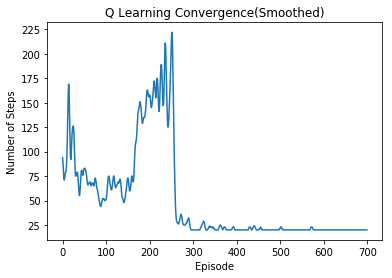

In [7]:
agent.show_convergence(rounds=700)

In [8]:
min(agent.steps)

20

#### Optimal Policy

In [9]:
agent.show_path()

---------------------------------------
|  right | right | right | right | down |
---------------------------------------
|  up | left | down | left | down |
---------------------------------------
|  right | up | down | up | down |
---------------------------------------
|  up | left | left | up | left |
---------------------------------------
